## Data prep

In [42]:
from spark_session_manager import SparkSessionManager

spark = SparkSessionManager.get_spark_session()

In [43]:
# schema for csv file

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType

schema = StructType([
    StructField("video_id", StringType(), True),
    StructField("title", StringType(), True),
    StructField("publishedAt", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("categoryId", StringType(), True),
    StructField("trending_date", StringType(), True),
    StructField("tags", StringType(), True),
    StructField("view_count", IntegerType(), True),
    StructField("likes", IntegerType(), True),
    StructField("dislikes", IntegerType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("thumbnail_link", StringType(), True),
    StructField("comments_disabled", BooleanType(), True),
    StructField("ratings_disabled", BooleanType(), True),
    StructField("description", StringType(), True)
])

In [44]:
file_path = 'data/US_youtube_trending_data.csv'  # Adjust the path accordingly

# Load your dataset into a Spark DataFrame
df = spark.read.csv(file_path, header=True, schema=schema, escape='"', quote='"', multiLine=True)

df.show()

+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|         publishedAt|           channelId|        channelTitle|categoryId|       trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|         description|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11T19:20:14Z|UCvtRTOMP2TqYqu51...|            Brawadis|        22|2020-08-12T00:00:00Z|brawadis|prank|ba...|   1514614|156908|    5855|        35313|ht

In [45]:
# Print the schema of the DataFrame
df.printSchema()

# Show the first few rows of the DataFrame
df.show(5)


root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)

+-----------+--------------------+--------------------+--------------------+-------------+----------+--------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|         publi

### Data Type Conversion

In [46]:
from pyspark.sql.functions import col

# List of columns to convert from string to integer
columns_to_convert = ['view_count', 'likes', 'dislikes', 'comment_count']

# Convert columns
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast('int'))

#### Date Formatting

In [47]:
# from pyspark.sql.functions import to_date

# # Convert date columns to date type
# df = df.withColumn("publishedAt", to_date(col("publishedAt"), "yyyy-MM-dd'T'HH:mm:ss'Z'"))
# df = df.withColumn("trending_date", to_date(col("trending_date"), "yyyy-MM-dd"))

# # Show the first few rows of the DataFrame
# df.show(5)

#### Handling Missing Values

In [48]:
# Drop rows with any missing values
df_cleaned = df.na.drop()

# Or fill missing values with a default value
df_filled = df.na.fill({"likes": 0, "dislikes": 0, "comment_count": 0})  # Example for numeric columns


In [49]:
from chart_defaults import *

## Add category names

specify schema

In [50]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql.functions import explode

schema = StructType([
    StructField("items", ArrayType(StructType([
        StructField("id", StringType(), True),
        StructField("snippet", StructType([
            StructField("title", StringType(), True),
            StructField("assignable", StringType(), True),
            StructField("channelId", StringType(), True)
        ]), True)
    ])), True)
])

category_json_df = spark.read.schema(schema).json("data/US_category_id.json")
category_df = category_json_df.select(explode("items").alias("category_item"))
category_df = category_df.select(
    "category_item.id",
    "category_item.snippet.title"
)


read json file

In [51]:
category_json_df = spark.read.option("multiline", "true").json("data/US_category_id.json")

category_df = category_json_df.select(explode("items").alias("category_item"))
category_df = category_df.select(
    col("category_item.id").alias("categoryId"),
    col("category_item.snippet.title").alias("categoryTitle")
)


convert categoryid type

In [52]:
df = df.withColumn("categoryId", col("categoryId").cast("string"))

join dfs

In [53]:
# Perform the join
df = df.join(category_df, on="categoryId", how="left")

# Show some results to verify the join worked as expected
df.select("video_id", "title", "categoryTitle").show(5)


+-----------+--------------------+--------------+
|   video_id|               title| categoryTitle|
+-----------+--------------------+--------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|People & Blogs|
|M9Pmf9AB4Mo|Apex Legends | St...|        Gaming|
|J78aPJ3VyNs|I left youtube fo...| Entertainment|
|kXLn3HkpjaA|XXL 2020 Freshman...|         Music|
|VIUo6yapDbc|Ultimate DIY Home...| Howto & Style|
+-----------+--------------------+--------------+
only showing top 5 rows



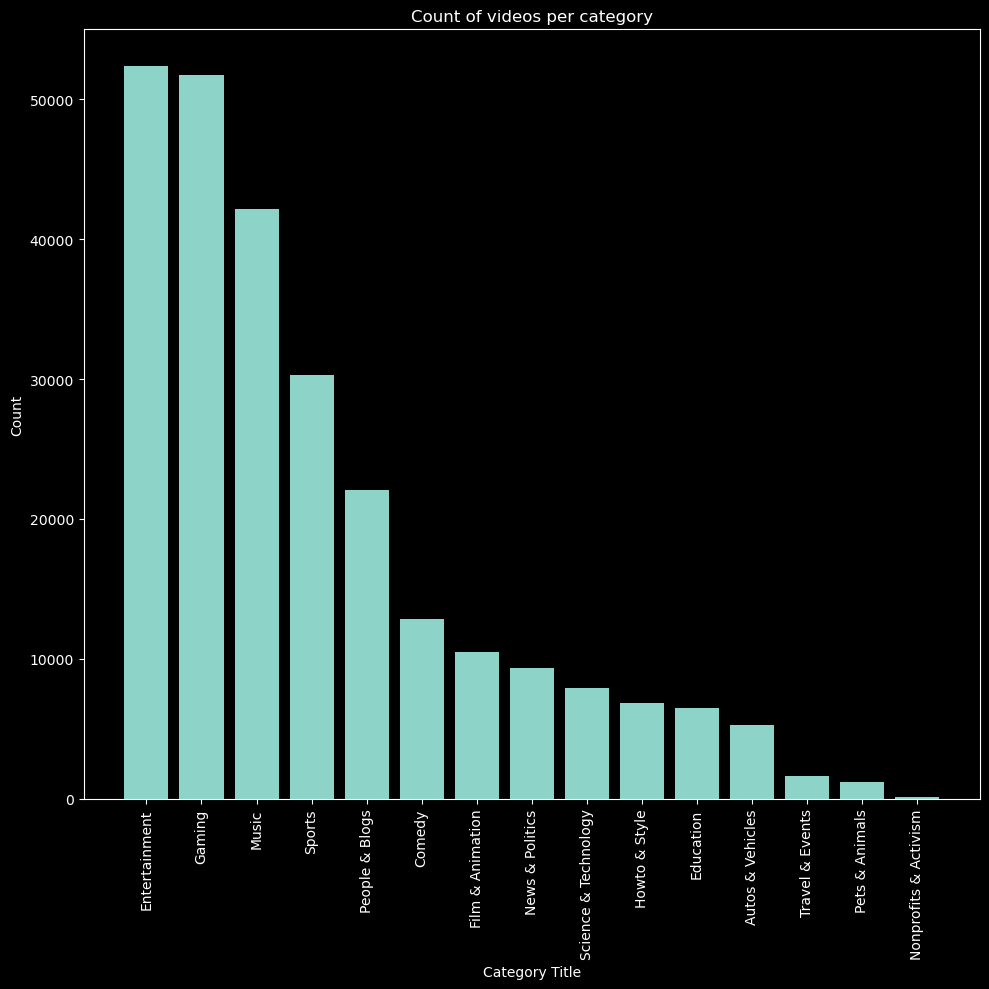

In [54]:

import matplotlib.pyplot as plt

plt.style.use('dark_background')

category_counts = df.groupBy("categoryId").count().toPandas()

# sort the x-axis labels by count
category_counts = category_counts.sort_values("count", ascending=False)

# xaxis labels should be category titles
category_titles = df.select("categoryId", "categoryTitle").distinct().toPandas()
category_titles = category_titles.set_index("categoryId")

category_counts["categoryTitle"] = category_counts["categoryId"].apply(lambda x: category_titles.loc[x]["categoryTitle"])

plt.figure(figsize=(10, 10))
plt.bar(category_counts["categoryTitle"], category_counts["count"])
plt.xlabel("Category Title")
plt.ylabel("Count")
plt.title("Count of videos per category")


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Engagement

### Engagement metrics

a lot of values in column dislikes are '0', thus eng. metrics will not use it

- view_to_like_ratio = view_count / likes
- like_to_comment_ratio = likes / comment_count
- engagement_rate = ((likes + comment_count) / view_count) * 100
- comments_per_view = comment_count / view_count

In [55]:
# introduce engagement metrics

from pyspark.sql import functions as F


#### introduce eng. metrics

In [56]:
df = df.withColumn("view_to_like_ratio", F.col("view_count") / F.col("likes")) \
    .withColumn("like_to_comment_ratio", F.col("likes") / F.col("comment_count")) \
    .withColumn("engagement_rate", ((F.col("likes") + F.col("comment_count")) / F.col("view_count")) * 100) \
    .withColumn("comments_per_view", F.col("comment_count") / F.col("view_count")) \
    .withColumn("average_views_per_day", F.col("view_count") / F.datediff(F.col("trending_date"), F.col("publishedAt")))


In [57]:
# Show the first few rows of the DataFrame (dont truncate)
df.show(5, truncate=False)

+----------+-----------+------------------------------------------------------------+--------------------+------------------------+-------------+--------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------+--------+-------------+----------------------------------------------+-----------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Calculate Engagement Metrics by Category

In [58]:
# calculate avg, median, min, max, std for each metric for each category

eng_metrics_by_category = df.groupBy("categoryTitle").agg(
    F.avg("view_to_like_ratio").alias("avg_view_to_like_ratio"),
    F.avg("like_to_comment_ratio").alias("avg_like_to_comment_ratio"),
    F.avg("engagement_rate").alias("avg_engagement_rate"),
    F.avg("comments_per_view").alias("avg_comments_per_view"),
    F.avg("average_views_per_day").alias("avg_average_views_per_day"),
    F.stddev("view_to_like_ratio").alias("stddev_view_to_like_ratio"),
    F.stddev("like_to_comment_ratio").alias("stddev_like_to_comment_ratio"),
    F.stddev("engagement_rate").alias("stddev_engagement_rate"),
    F.stddev("comments_per_view").alias("stddev_comments_per_view"),
    F.stddev("average_views_per_day").alias("stddev_average_views_per_day"),
    F.min("view_to_like_ratio").alias("min_view_to_like_ratio"),
    F.min("like_to_comment_ratio").alias("min_like_to_comment_ratio"),
    F.min("engagement_rate").alias("min_engagement_rate"),
    F.min("comments_per_view").alias("min_comments_per_view"),
    F.min("average_views_per_day").alias("min_average_views_per_day"),
    F.max("view_to_like_ratio").alias("max_view_to_like_ratio"),
    F.max("like_to_comment_ratio").alias("max_like_to_comment_ratio"),
    F.max("engagement_rate").alias("max_engagement_rate"),
    F.max("comments_per_view").alias("max_comments_per_view"),
    F.max("average_views_per_day").alias("max_average_views_per_day"),
    F.expr("percentile_approx(view_to_like_ratio, 0.5)").alias("median_view_to_like_ratio"),
    F.expr("percentile_approx(like_to_comment_ratio, 0.5)").alias("median_like_to_comment_ratio"),
    F.expr("percentile_approx(engagement_rate, 0.5)").alias("median_engagement_rate"),
    F.expr("percentile_approx(comments_per_view, 0.5)").alias("median_comments_per_view"),
    F.expr("percentile_approx(average_views_per_day, 0.5)").alias("median_average_views_per_day")
)

In [59]:
# show the dataframe
eng_metrics_by_category.show()

+--------------------+----------------------+-------------------------+-------------------+---------------------+-------------------------+-------------------------+----------------------------+----------------------+------------------------+----------------------------+----------------------+-------------------------+--------------------+---------------------+-------------------------+----------------------+-------------------------+-------------------+---------------------+-------------------------+-------------------------+----------------------------+----------------------+------------------------+----------------------------+
|       categoryTitle|avg_view_to_like_ratio|avg_like_to_comment_ratio|avg_engagement_rate|avg_comments_per_view|avg_average_views_per_day|stddev_view_to_like_ratio|stddev_like_to_comment_ratio|stddev_engagement_rate|stddev_comments_per_view|stddev_average_views_per_day|min_view_to_like_ratio|min_like_to_comment_ratio| min_engagement_rate|min_comments_per_vie

#### charts

In [60]:
# graph one by one of the columns on bar chart

# convert the spark dataframe to pandas dataframe
eng_metrics_by_category_pd = eng_metrics_by_category.toPandas()

import plotly.graph_objects as go
import numpy as np


# Assuming eng_metrics_by_category_pd is the pandas DataFrame converted from Spark DataFrame

def plot_bar_chart(df, column_name):
    # Create a bar chart using Plotly, with colors based on the column values
    fig = go.Figure(data=[go.Bar(
        x=df['categoryTitle'],
        y=df[column_name],
        marker=dict(color=df[column_name], colorscale='Viridis')  # Apply color based on column value
    )])
    fig.update_layout(title_text=column_name, xaxis_title='Category Title', yaxis_title=column_name)
    # Hide legend (since it's not needed here)
    fig.update_layout(showlegend=False)

    # vertical text
    fig.update_layout(xaxis_tickangle=-45)

    # add mean line, full width of paper
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=df[column_name].mean(),
        x1=len(df['categoryTitle']) - 0.5,
        y1=df[column_name].mean(),
        line=dict(
            color="red",
            width=2
        )
    )

    fig.show()

for column in eng_metrics_by_category_pd.columns:
    if column != "categoryTitle":
        plot_bar_chart(eng_metrics_by_category_pd, column)


## Saving Processed Data


In [61]:
# subset data
df_subset = df.select("video_id", "title", "categoryTitle", "view_to_like_ratio", "like_to_comment_ratio", "engagement_rate", "comments_per_view", "average_views_per_day")

In [62]:
# Example: Specifying an absolute path and ensuring the directory exists
import os

output_path = "data/processed/engage_metrics_data.parquet"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_subset.write.mode('overwrite').parquet(output_path)

In [63]:
df_subset.show(
    5,
    truncate=False
)

+-----------+------------------------------------------------------------+--------------+------------------+---------------------+-----------------+--------------------+---------------------+
|video_id   |title                                                       |categoryTitle |view_to_like_ratio|like_to_comment_ratio|engagement_rate  |comments_per_view   |average_views_per_day|
+-----------+------------------------------------------------------------+--------------+------------------+---------------------+-----------------+--------------------+---------------------+
|3C66w5Z0ixs|I ASKED HER TO BE MY GIRLFRIEND...                          |People & Blogs|9.652879394294747 |4.443349474697704    |12.69108829048193|0.023314851176603413|1514614.0            |
|M9Pmf9AB4Mo|Apex Legends | Stories from the Outlands – “The Endorsement”|Gaming        |16.230777094024084|8.866940600640522    |6.855977777105986|0.006948433212074797|2381688.0            |
|J78aPJ3VyNs|I left youtube for a month 

In [64]:
df.describe(["view_count", "likes", "dislikes", "comment_count"]).show()


+-------+-----------------+-----------------+-----------------+------------------+
|summary|       view_count|            likes|         dislikes|     comment_count|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|           260787|           260787|           260787|            260787|
|   mean|2692467.785077477|131219.9604351444|1169.073017443354|10208.705188525502|
| stddev|8729430.316258594| 452251.692125242|8167.300333295543| 73606.70150388542|
|    min|                0|                0|                0|                 0|
|    max|        277791741|         16021534|           879354|           6738537|
+-------+-----------------+-----------------+-----------------+------------------+



## Category Distribution

In [65]:
from pyspark.sql.functions import col

df.groupBy("categoryTitle").count().orderBy(col("count").desc()).show()


+--------------------+-----+
|       categoryTitle|count|
+--------------------+-----+
|       Entertainment|52387|
|              Gaming|51741|
|               Music|42139|
|              Sports|30298|
|      People & Blogs|22036|
|              Comedy|12840|
|    Film & Animation|10514|
|     News & Politics| 9328|
|Science & Technology| 7909|
|       Howto & Style| 6853|
|           Education| 6456|
|    Autos & Vehicles| 5303|
|     Travel & Events| 1654|
|      Pets & Animals| 1209|
|Nonprofits & Acti...|  120|
+--------------------+-----+



## tag freq

In [66]:
from pyspark.sql.functions import explode, split

# Split the tags string into an array of tags, then explode the array into individual rows
tags_df = df.withColumn("tag", explode(split("tags", "\|")))

# Group by the individual tags and count occurrences
tag_counts = tags_df.groupBy("tag").count().orderBy("count", ascending=False).limit(20).toPandas()

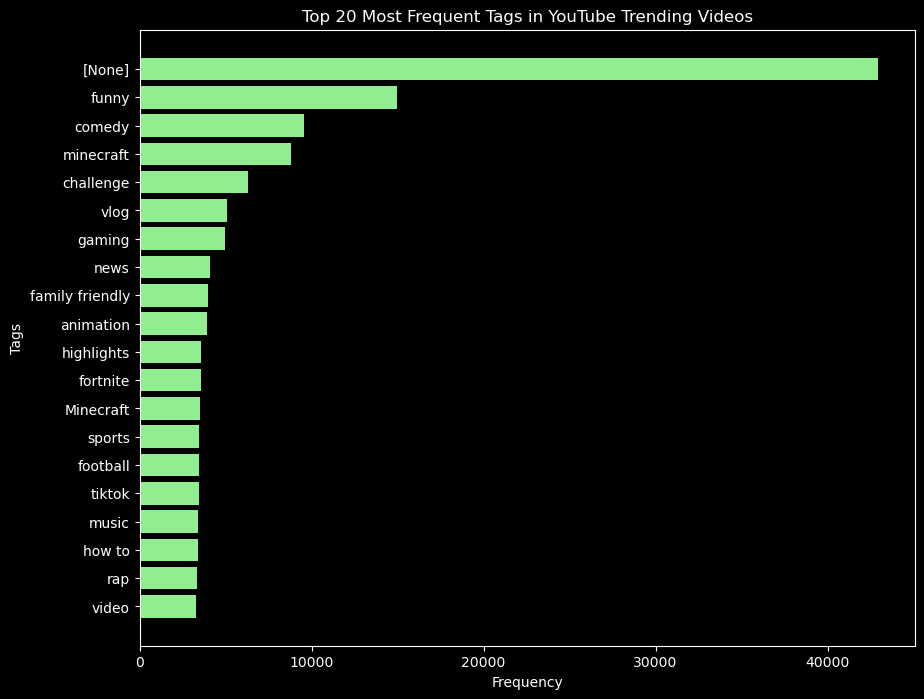

In [67]:
plt.figure(figsize=(10, 8))
plt.barh(tag_counts['tag'], tag_counts['count'], color='lightgreen')
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Frequent Tags in YouTube Trending Videos')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent tag at the top
plt.show()


## Correlation Analysis

In [68]:
numeric_features = ["view_count", "likes", "dislikes", "comment_count"]
for i in numeric_features:
    for j in numeric_features:
        if i != j:  # Avoid comparing a variable with itself
            print(f"Correlation between {i} and {j}: ", df.stat.corr(i, j))


Correlation between view_count and likes:  0.8775228350162698


Correlation between view_count and dislikes:  0.35551205161845817


Correlation between view_count and comment_count:  0.5225916085460038


Correlation between likes and view_count:  0.8775228350162697


Correlation between likes and dislikes:  0.38891483068449223


Correlation between likes and comment_count:  0.6891492201977686


Correlation between dislikes and view_count:  0.3555120516184583


Correlation between dislikes and likes:  0.38891483068449223


Correlation between dislikes and comment_count:  0.417436511796521


Correlation between comment_count and view_count:  0.5225916085460038


Correlation between comment_count and likes:  0.6891492201977686


Correlation between comment_count and dislikes:  0.417436511796521


In [69]:
# build a correlation matrix
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
df_vector = assembler.transform(df)

from pyspark.ml.stat import Correlation

pearson_corr = Correlation.corr(df_vector, "features").head()

print("Pearson correlation matrix:\n" + str(pearson_corr[0]))



Pearson correlation matrix:
DenseMatrix([[1.        , 0.87752284, 0.35551205, 0.52259161],
             [0.87752284, 1.        , 0.38891483, 0.68914922],
             [0.35551205, 0.38891483, 1.        , 0.41743651],
             [0.52259161, 0.68914922, 0.41743651, 1.        ]])


In [70]:
# use plotly go.Figure to visualize the correlation matrix
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
    z=pearson_corr[0].toArray(),
    x=numeric_features,
    y=numeric_features,
    colorscale='Greens'))

# add labels with values
for i in range(len(numeric_features)):
    for j in range(len(numeric_features)):
        fig.add_annotation(
            x=i, y=j,
            text=str(round(pearson_corr[0].toArray()[i][j], 2)),
            showarrow=False)

# change style of labels to Monospace white font with black outline
fig.update_yaxes(tickfont=dict(color='black', family='Courier New, monospace', size=18))
fig.update_xaxes(tickfont=dict(color='black', family='Courier New, monospace', size=18))

fig.update_layout(
    title="Correlation matrix of numerical features",
    title_x=0.5,
    width=800,
    height=800,
    # change label font
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="black"
    )
)

fig.show()

## Time Series Analysis


In [71]:
from pyspark.sql.functions import to_date

df.withColumn("publishedAt_date", to_date("publishedAt")).groupBy("publishedAt_date").sum("view_count").orderBy("publishedAt_date").show()

+----------------+---------------+
|publishedAt_date|sum(view_count)|
+----------------+---------------+
|      2020-08-03|        8257287|
|      2020-08-05|       15711937|
|      2020-08-06|       92448003|
|      2020-08-07|      637964497|
|      2020-08-08|      305669994|
|      2020-08-09|      255042172|
|      2020-08-10|      178660898|
|      2020-08-11|      525409368|
|      2020-08-12|      120581624|
|      2020-08-13|      574566491|
|      2020-08-14|      907164535|
|      2020-08-15|      407042731|
|      2020-08-16|      305527729|
|      2020-08-17|      772416732|
|      2020-08-18|      695655425|
|      2020-08-19|      366439033|
|      2020-08-20|      355228147|
|      2020-08-21|     1954903659|
|      2020-08-22|      315550934|
|      2020-08-23|      521486151|
+----------------+---------------+
only showing top 20 rows



## Distribution

In [72]:
# For numerical columns
numerical_cols = ['view_count', 'likes', 'dislikes', 'comment_count']
df.select(numerical_cols).describe().show()

+-------+-----------------+-----------------+-----------------+------------------+
|summary|       view_count|            likes|         dislikes|     comment_count|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|           260787|           260787|           260787|            260787|
|   mean|2692467.785077477|131219.9604351444|1169.073017443354|10208.705188525502|
| stddev|8729430.316258594| 452251.692125242|8167.300333295543| 73606.70150388542|
|    min|                0|                0|                0|                 0|
|    max|        277791741|         16021534|           879354|           6738537|
+-------+-----------------+-----------------+-----------------+------------------+



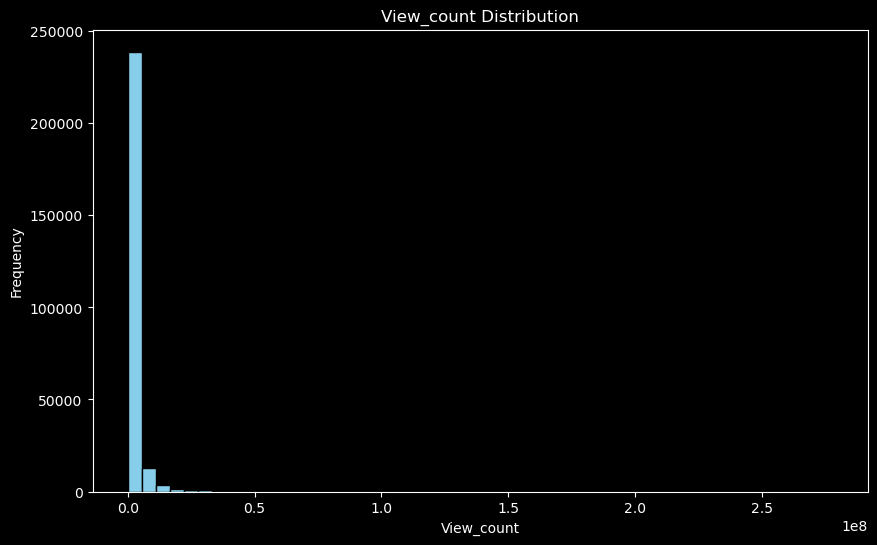

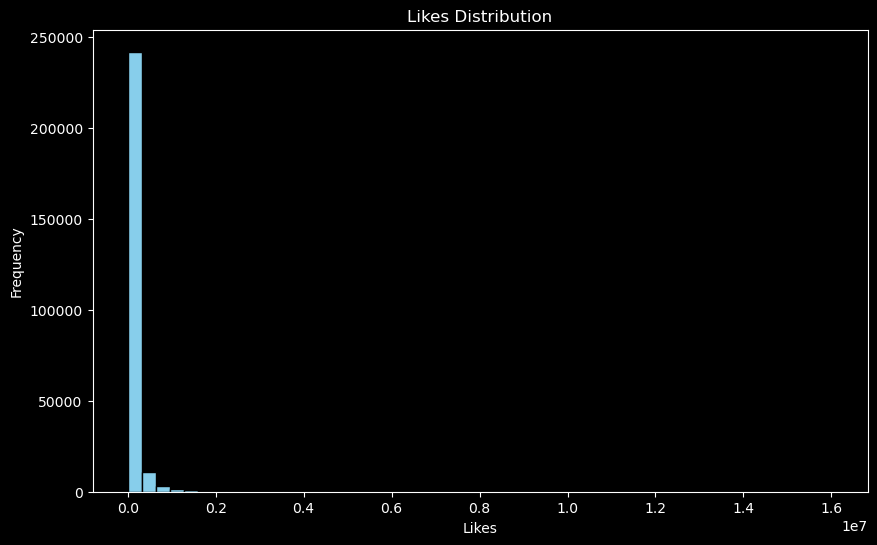

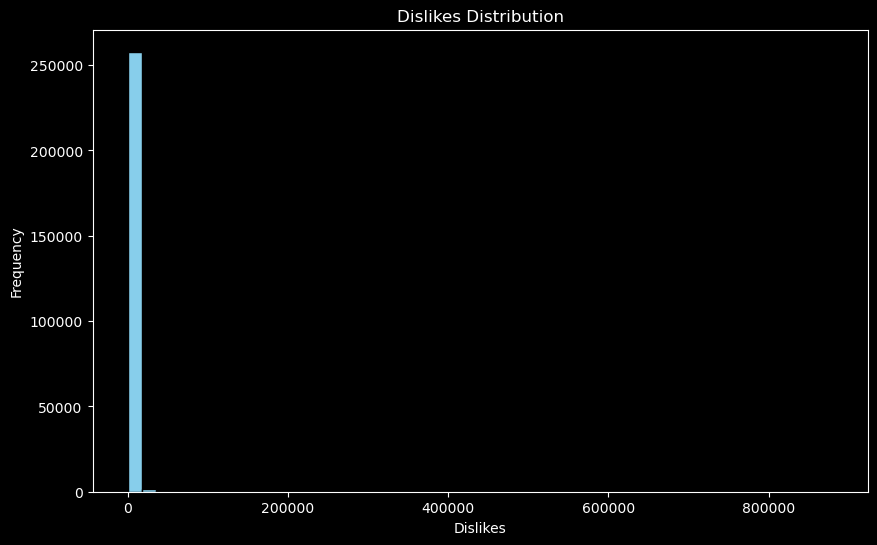

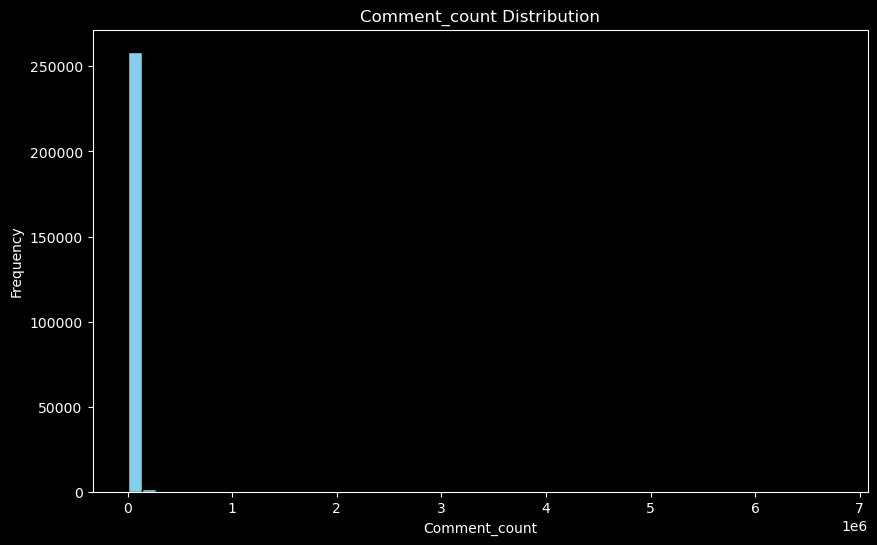

In [73]:
import matplotlib.pyplot as plt

def plot_histograms(df, columns, bins=50):
    """
    Plots histograms for the specified continuous variables in a Spark DataFrame.
    
    Parameters:
    - df: Spark DataFrame containing the data.
    - columns: List of column names (strings) for which to plot histograms.
    - bins: Number of bins to use in the histograms (default is 50).
    """
    for column in columns:
        # Aggregate data in Spark
        data = df.select(column).rdd.flatMap(lambda x: x).collect()
        
        # Plot using Matplotlib in Python
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'{column.capitalize()} Distribution')
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.show()

# Example usage with your DataFrame and continuous variables
continuous_vars = ['view_count', 'likes', 'dislikes', 'comment_count']
plot_histograms(df, continuous_vars)


above plots show that all continuous variables are heaviliy right-tail skewed, therefore log transformation might be beneficial

## Transformations

In [74]:
from pyspark.sql.functions import log1p

# Apply log transformation to each specified column
for column in continuous_vars:
    # Add a new column with the log transformation applied
    df = df.withColumn(column + '_log', log1p(col(column)))

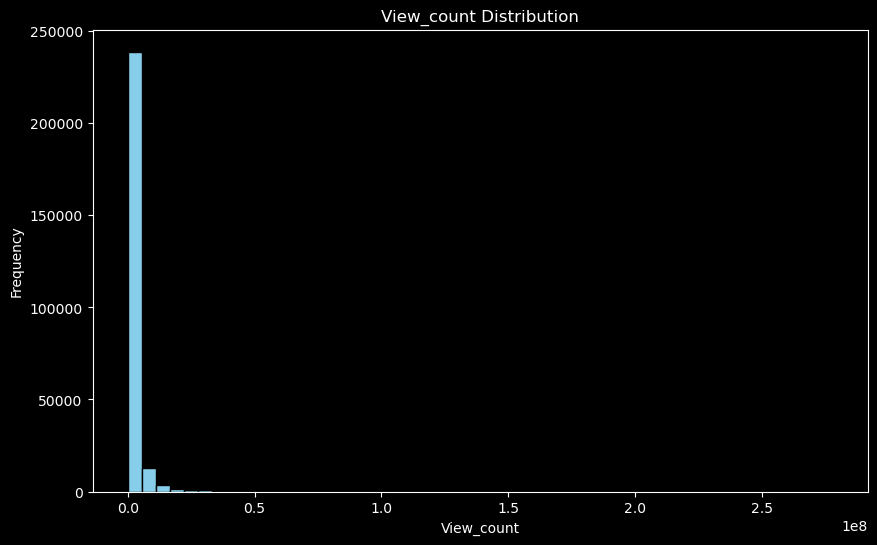

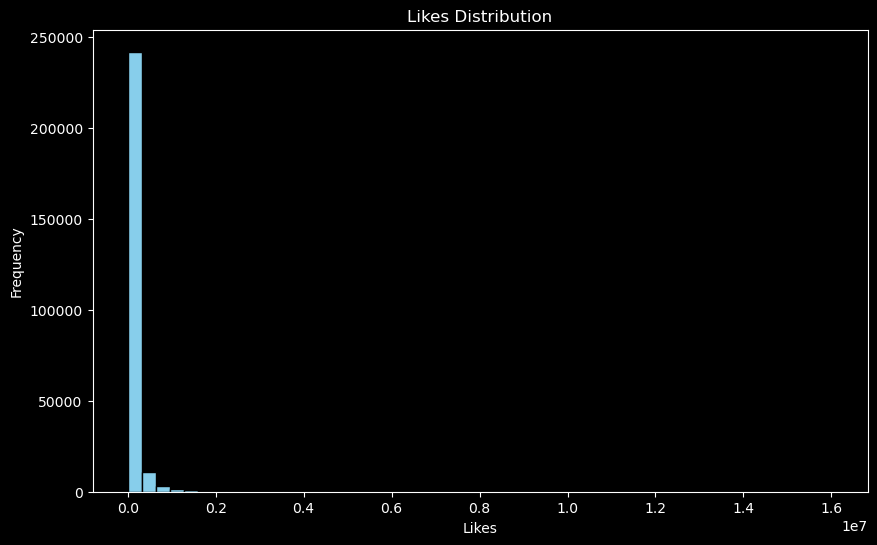

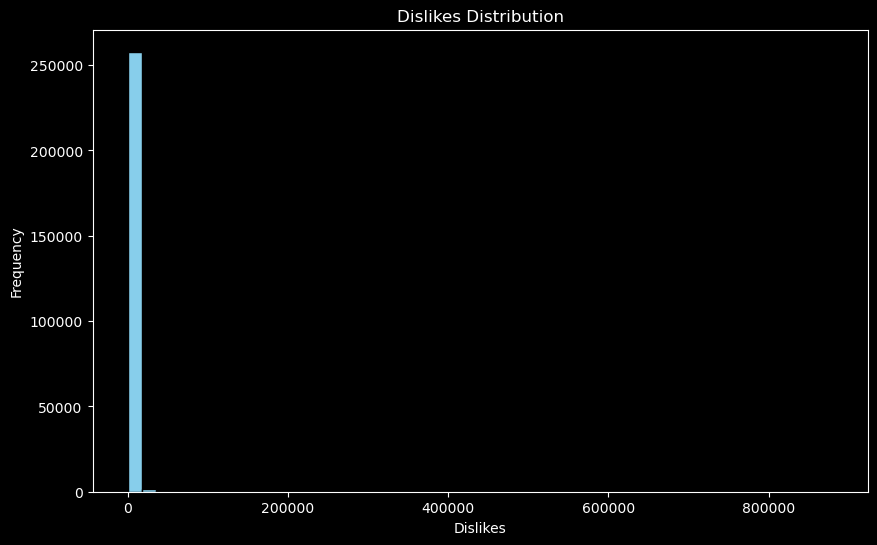

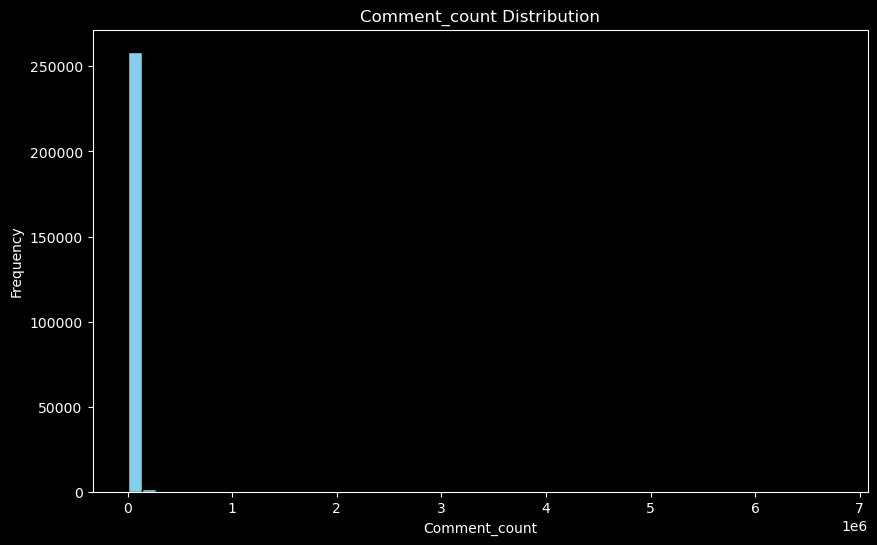

In [75]:
# Replot histograms for the log-transformed variables
plot_histograms(df, continuous_vars)


### Categorical Variables

#### Aggregate Category Popularity

In [76]:
# For a categorical column like 
category_popularity = df.groupBy("categoryTitle").count().orderBy("count", ascending=False).toPandas()

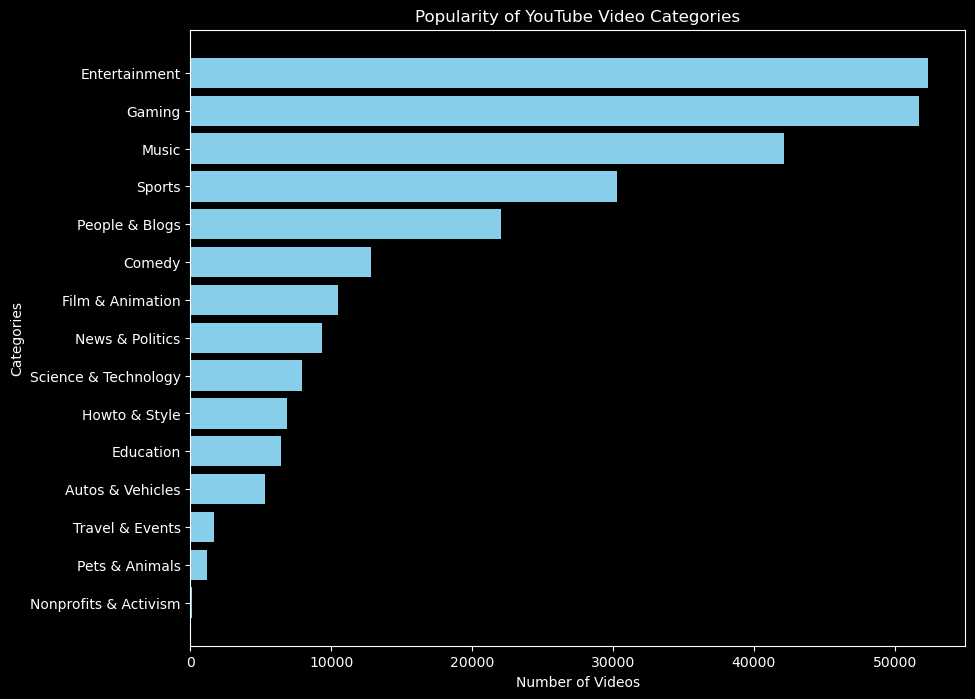

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(category_popularity['categoryTitle'], category_popularity['count'], color='skyblue')
plt.xlabel('Number of Videos')
plt.ylabel('Categories')
plt.title('Popularity of YouTube Video Categories')
plt.gca().invert_yaxis()  # Invert y-axis to have the most popular category at the top

# use skin 
plt.style.use('dark_background')


plt.show()


## save transformed data

In [78]:
# subset columns
# 'video_id', 'title', 'categoryTitle', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count' + logged versions

df = df.select('video_id', 'title', 'categoryTitle', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'view_count_log', 'likes_log', 'dislikes_log', 'comment_count_log')

In [79]:
# save parquet file
df.write.parquet("data/processed/tranformed_US_youtube_trending_data.parquet", mode="overwrite")

In [80]:
# df_with_categories to pandas
# df_with_categories = df_with_categories.toPandas()
df.head(5)

df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- categoryTitle: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- view_count_log: double (nullable = true)
 |-- likes_log: double (nullable = true)
 |-- dislikes_log: double (nullable = true)
 |-- comment_count_log: double (nullable = true)

